Initial code for deepfake detection

In [2]:
import os
import pandas as pd
import random
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

2024-02-27 18:54:47.401694: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 18:54:47.492640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 18:54:47.492685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 18:54:47.494752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 18:54:47.508636: I tensorflow/core/platform/cpu_feature_guar

In [5]:
metadata = pd.read_json('dataset0/metadata.json').transpose()
metadata.reset_index(level=0, inplace=True)
metadata.rename(columns={'index':'filename'}, inplace=True)
metadata.tail(12)

,filename,label,split,original
1322,ioolqahamw.mp4,FAKE,train,fsaronfupy.mp4
1323,jccvzepxjn.mp4,FAKE,train,vmxfwxgdei.mp4
1324,dflpzzixje.mp4,FAKE,train,nhsijqpoda.mp4
1325,vmxfwxgdei.mp4,REAL,train,NaN
1326,jgzwhkcrcc.mp4,FAKE,train,jytrvwlewz.mp4
1327,nyxrmccdss.mp4,FAKE,train,jzupayeuln.mp4
1328,aayrffkzxn.mp4,REAL,train,NaN
1329,hectzcuzdv.mp4,FAKE,train,vtunvalyji.mp4
1330,yxkbjxmtzr.mp4,FAKE,train,sttnfyptum.mp4
1331,wkdnagybtb.mp4,FAKE,train,jytrvwlewz.mp4


In [4]:
names = ["zyetffhvij.mp4","zxddbcqorr.mp4"]
metadata = metadata[metadata['filename'].isin(names)]
metadata.head()

,filename,label,split,original


In [4]:
def extract_frames(video_path, interval_seconds):
    capture = cv2.VideoCapture(video_path)
    frame_rate = capture.get(cv2.CAP_PROP_FPS)
    interval_frames = int(frame_rate * interval_seconds)

    frames = []
    frame_idx = 0
    while True:
        ret, frame = capture.read()
        if not ret:
            break
        if frame_idx % interval_frames == 0:
            frames.append(frame)
        frame_idx += 1

    capture.release()
    return frames

def extract_keyframes(video_path):
    capture = cv2.VideoCapture(video_path)
    frame_rate = capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define key frame selection criteria
    keyframes = []

    _, prev_frame = capture.read()
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    for frame_idx in range(1, total_frames):
        _, current_frame = capture.read()
        current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

        # Calculate absolute difference between frames
        frame_diff = cv2.absdiff(prev_frame_gray, current_frame_gray)

        # Threshold the difference to identify significant changes
        _, threshold_diff = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)

        # Count non-zero pixels in the thresholded difference
        non_zero_pixels = np.count_nonzero(threshold_diff)

        # Define a threshold for considering a frame as a keyframe
        threshold_keyframe = 0.02 * current_frame.size

        # If the number of non-zero pixels exceeds the threshold, consider it a keyframe
        if non_zero_pixels > threshold_keyframe:
            keyframes.append(current_frame)

        prev_frame_gray = current_frame_gray

    capture.release()
    return keyframes

def extract_frames_rand(video_path, num_frames_to_select):
    capture = cv2.VideoCapture(video_path)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # Randomly select frames
    selected_frame_indices = random.sample(range(total_frames), num_frames_to_select)
    selected_frames = []

    for frame_idx in selected_frame_indices:
        capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = capture.read()
        if ret:
            selected_frames.append(frame)

    capture.release()
    return selected_frames

def extract_face(frame):
    detector = MTCNN()
    faces = detector.detect_faces(frame)
    if faces:
        x, y, w, h = faces[0]['box']
        face = frame[y:y + h, x:x + w]
        return cv2.resize(face, (224, 224))
    else:
        return None

In [5]:
# Functions check


v_path = "dataset0/aaqaifqrwn.mp4"

# Extract frames
frames = extract_frames(v_path, 4)

# Extract random frames
rand_frames = extract_frames_rand(v_path, 3)

# Extract all face
uniform_faces=[]
for i in range(len(frames)):
    face = extract_face(frames[i])
    if face is not None:
        uniform_faces.append(face)
        print(f'Face detected in frame {i}')

random_faces=[]
for i in range(len(rand_frames)):
    face = extract_face(rand_frames[i])
    if face is not None:
        random_faces.append(face)
        print(f'Face detected in random frame {i}')

# Display results
print(f'Extracted {len(frames)} frames')
# print(f'Extracted {len(keyframes)} keyframes')
print(f'Extracted {len(rand_frames)} random frames')
print(f'Extracted {len(uniform_faces)} uniform faces')
print(f'Extracted {len(random_faces)} random faces')


2024-02-19 09:34:12.776489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 09:34:12.815929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 09:34:12.816035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 09:34:12.820734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 09:34:12.820815: I external/local_xla/xla/stream_executor

1/1 [==============================] - 1s 505ms/step
Face detected in frame 0
1/1 [==============================] - 0s 491ms/step
Face detected in frame 1
1/1 [==============================] - 0s 459ms/step
Face detected in frame 2
1/1 [==============================] - 0s 181ms/step
Face detected in random frame 0
1/1 [==============================] - 0s 189ms/step
Face detected in random frame 1
1/1 [==============================] - 0s 174ms/step
Face detected in random frame 2
Extracted 3 frames
Extracted 3 random frames
Extracted 3 uniform faces
Extracted 3 random faces


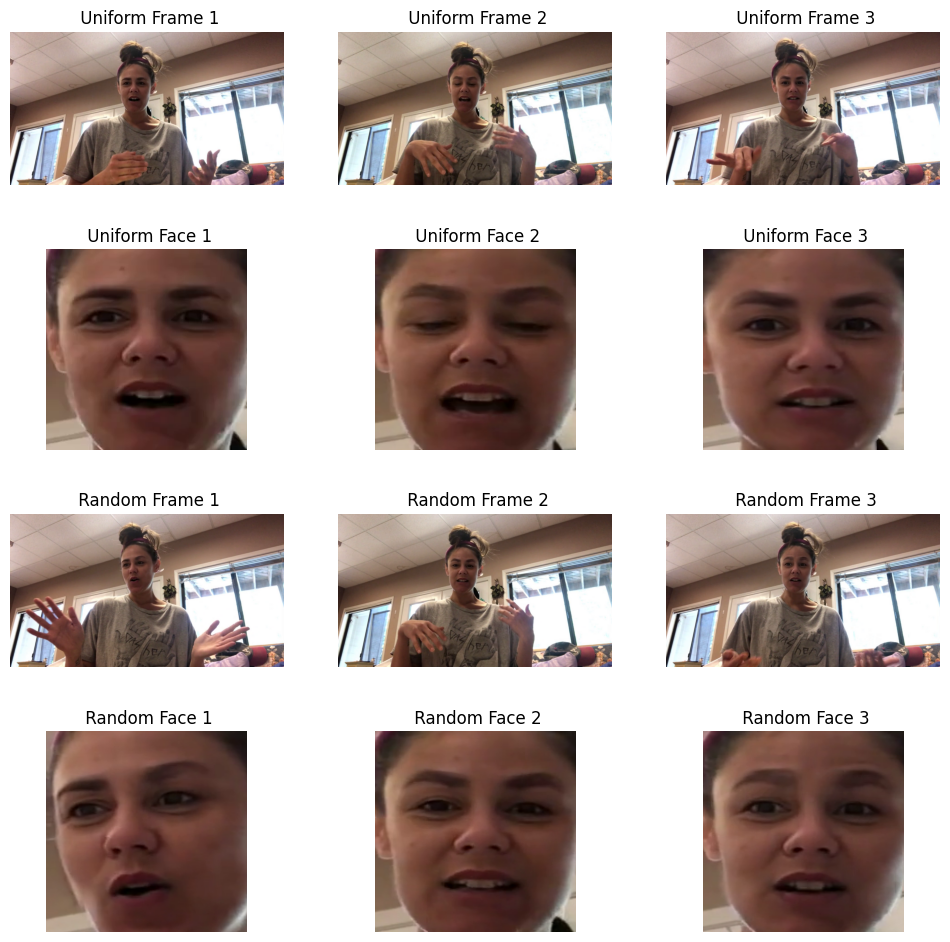

In [6]:
# display frames and face in a grid
import matplotlib.pyplot as plt

#display 3 frames in a row and display the face seperately with titles

fig, ax = plt.subplots(4,3, figsize=(12,12))
for i in range(3):
    ax[0,i].imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
    ax[0,i].set_title(f' Uniform Frame {i+1}')
    ax[0,i].axis('off')

for i in range(3):
    ax[1,i].imshow(cv2.cvtColor(uniform_faces[i], cv2.COLOR_BGR2RGB))
    ax[1,i].set_title(f' Uniform Face {i+1}')
    ax[1,i].axis('off')

for i in range(3):
    ax[2,i].imshow(cv2.cvtColor(rand_frames[i], cv2.COLOR_BGR2RGB))
    ax[2,i].set_title(f' Random Frame {i+1}')
    ax[2,i].axis('off')

for i in range(3):
    ax[3,i].imshow(cv2.cvtColor(random_faces[i], cv2.COLOR_BGR2RGB))
    ax[3,i].set_title(f' Random Face {i+1}')
    ax[3,i].axis('off')

plt.show()


In [ ]:
#save the faces to a folder
os.makedirs('faces/REAL', exist_ok=True)
os.makedirs('faces/FAKE', exist_ok=True)

for i in range(len(metadata)):
    filename = metadata.iloc[i]["filename"]
    v_path = f'dataset0/{metadata.iloc[i]["filename"]}'
    label = metadata.iloc[i]["label"]
    frames = extract_frames(v_path, 4)
    faces = []
    for frame in frames:
        face = extract_face(frame)
        if face is not None:
            faces.append(face)
    for j, face in enumerate(faces):
        cv2.imwrite(f'faces/{label}/{filename}_{j}.jpg', face)

In [ ]:
# data = []
# labels = []
# z=0
# for index, row in metadata.iterrows():
#     if z==30:
#         break
#     z+=1
#     print(z)
#     video_path = os.path.join('dataset0', row['filename'])
#     frames = extract_frames(video_path, interval_seconds=10)
#     for frame in frames:
#         print(len(frames))
#         face = extract_face(frame)
#         if face is not None:
#             data.append(img_to_array(face))
#             labels.append(1 if row['label'] == 'FAKE' else 0)